In [1]:
# import ros stuff
import rospy
import actionlib
import actionlib.msg
import sys, select
import assignment_2_2022.msg
from nav_msgs.msg import Odometry
from assignment_2_2022.msg import custom_msg
from std_srvs.srv import *
from geometry_msgs.msg import Twist, Pose, Point

import ipywidgets as widgets
import jupyros as jr
import time
from assignment_2_2022.srv import service_goals, service_goalsRequest
import matplotlib.pyplot as plt
import numpy as np
from sensor_msgs.msg import LaserScan
from matplotlib.animation import FuncAnimation
import math
%matplotlib widget

In [2]:
def publish_msg(message):
   
    global publisher
    global last_time_published_odom
        
    # Get the position and velocity
    pos_x = round(message.pose.pose.position.x, 1)
    pos_y = round(message.pose.pose.position.y, 1)
    vel_x = message.twist.twist.linear.x
    vel_y = message.twist.twist.linear.y

    # Creation of the custom message
    custom_message = custom_msg()
    
    custom_message.actual_x = pos_x
    custom_message.actual_y = pos_y
    custom_message.actual_vel_x = vel_x
    custom_message.actual_vel_y = vel_y
    
    # Publishing the custom message
    publisher.publish(custom_message)
    
    current_time = time.time() * 1000
    if current_time - last_time_published_odom > 100:
        print("\rRobot position: x={}, y={}".format(pos_x, pos_y), end='')
        last_time_published_odom = current_time

In [3]:
def on_send_goal_button_clicked(b):
    # Call 'action_cliient' function
    action_client()
    
def action_client():
    global goal

    # Creation of the goal for the robot
    goal = assignment_2_2022.msg.PlanningGoal()
    goal.target_pose.pose.position.x = w_coordinate_x.value
    goal.target_pose.pose.position.y = w_coordinate_y.value

    # Send goal to the server
    act_client.send_goal(goal)

In [4]:
def on_cancel_goal_button_clicked(b):
    global goal
    
    # Cancel the goal
    act_client.cancel_goal()
    
    goal = None

In [5]:
# Widgets to give the goal coordinates
w_coordinate_x = widgets.FloatText(description='Coordinate X:', step = 0.1)
w_coordinate_y = widgets.FloatText(description='Coordinate Y:', step = 0.1)

# Button to send the goal
send_goal_button = widgets.Button(
description='Send goal to the robot',
layout = widgets.Layout(width = 'auto'))

send_goal_button.on_click(on_send_goal_button_clicked)

# Button to cancel the goal
cancel_goal_button = widgets.Button(
description='Cancel goal sent to the robot',
layout = widgets.Layout(width = 'auto'))

cancel_goal_button.on_click(on_cancel_goal_button_clicked)

In [ ]:
def callback_laser_scan(laser_scan):
    global last_time_published_laser
    
    # Only consider obstacles in a 180° field of view in front of the robot
    index_start = len(laser_scan.ranges) // 2 - (len(laser_scan.ranges) // 4)
    index_end = len(laser_scan.ranges) // 2 + (len(laser_scan.ranges) // 4)
    ranges = laser_scan.ranges[index_start:index_end]
    min_distance = round(min(ranges),1)
    
    # Print the distance every 100 ms
    current_time = time.time() * 1000
    if current_time - last_time_published_laser > 100:
        print("\rDistance from the closest obstacle: {}".format(min_distance), end='')
        last_time_published_laser = current_time

In [6]:
def call_Node_B():
    rospy.wait_for_service('/Node_B')
    Node_B_serviceProxy = rospy.ServiceProxy('/Node_B', service_goals)
    response = Node_B_serviceProxy.service_goalsRequest()
    return response

In [ ]:
class PositionVisualizer:
    def __init__(self):
        # Init function
        self.fig, self.ax = plt.subplots()
        # Settings for robot's position plot
        self.ln, = plt.plot([], [], 'bo', label='Robot position')
        # Settings for target's position plot
        self.goal_ln, = plt.plot([], [], 'r*', markersize=10, label='Goal position')
        # Robot's position data arrays
        self.x_data, self.y_data = [], []
    
    def plot_init(self):
        # Set axis limits
        self.ax.set_xlim(10, -10)
        self.ax.set_ylim(10, -10)
        # Set the grid
        self.ax.grid(True, color='lightgrey')
        # Set the title
        self.ax.set_title('Robot position')
        # Set the legend
        self.ax.legend(loc='upper left')
        
        return self.ln, self.goal_ln
    
    def odom_callback(self, message):
        # Callback function to update the data arrays
        self.x_data.append(message.pose.pose.position.x)
        self.y_data.append(message.pose.pose.position.y)
    
    def update_plot(self, frame):
        # Update the robot position plot
        self.ln.set_data(self.x_data, self.y_data)

        if goal is not None:
            self.goal_ln.set_data(goal.target_pose.pose.position.x, goal.target_pose.pose.position.y)
        else:
            self.goal_ln.set_data([], [])
        return self.ln, self.goal_ln

In [7]:
class GoalsVisualizer:
    def __init__(self):
        # Initialize the figure and axis
        self.fig, self.ax = plt.subplots()
        self.ax.set_title('Goals reached/cancelled')
        
        # Set up the initial values for the two bars
        self.reached = 0
        self.cancelled = 0
        
        # Set up the horizontal grid
        self.ax.grid(axis='y', color='grey', linestyle='-', alpha=0.5)
        
        # Set up the x-axis tick labels
        self.labels = ('Reached', 'Cancelled')
        self.x_pos = np.arange(len(self.labels))
        self.ax.set_xticks(self.x_pos)
        self.ax.set_xticklabels(self.labels)
        
        # Set up the y-axis range and ticks
        self.ax.set_ylim([0, 10])
        self.ax.set_yticks(np.arange(0, 11, 1))
        
        # Set up the bar chart
        self.bar_colors = ['green', 'red']
        self.bar_plot = self.ax.bar(self.x_pos,
                                    [self.reached, self.cancelled],
                                    align='center',
                                    color=self.bar_colors,
                                    width=0.2)
        
    def goals_callback(self, message):
        # Get the number of reached and cancelled goals
        response = call_service()
        self.reached = response.count_goals_reached
        self.cancelled = response.count_goals_cancelled
        
    def update_plot(self, frame):
        # Update the values of the two bars
        self.green_val = np.random.randint(0, 100)
        self.red_val = np.random.randint(0, 100)
        
        # Update the heights of the bars
        for i, bar in enumerate(self.bar_plot):
            if i == 0:
                bar.set_height(self.reached)
            else:
                bar.set_height(self.cancelled)
                
            bar.set_color(self.bar_colors[i])
        
        return self.bar_plot

In [8]:
# Creation of the node A
rospy.init_node('Jupyter')

# Creation of the Publisher
publisher = rospy.Publisher('/position_and_velocity', custom_msg, queue_size = 1)
    
# Creation of the action client
act_client = actionlib.SimpleActionClient('/reaching_goal', assignment_2_2022.msg.PlanningAction)

# Waiting the server
act_client.wait_for_server()
    
# Initialization
goal = None

In [9]:
last_time_published_odom = 0
jr.subscribe('/odom', Odometry, publish_msg)

In [ ]:
last_time_published_laser = 0
jr.subscribe('/scan', LaserScan, callback_laser_scan)

In [10]:
display(widgets.HBox([w_coordinate_x, w_coordinate_y]))
display(widgets.HBox([send_goal_button, cancel_goal_button]))

In [ ]:
# Create the visualizer object
position_visualizer = PositionVisualizer()
    
# Subscriber for the odom topic
sub = rospy.Subscriber('/odom', Odometry, position_visualizer.odom_callback)

# Plot
position_animation = FuncAnimation(
    position_visualizer.fig,
    position_visualizer.update_plot,
    init_func = position_visualizer.plot_init,
    cache_frame_data = False)
plt.show(block = True)

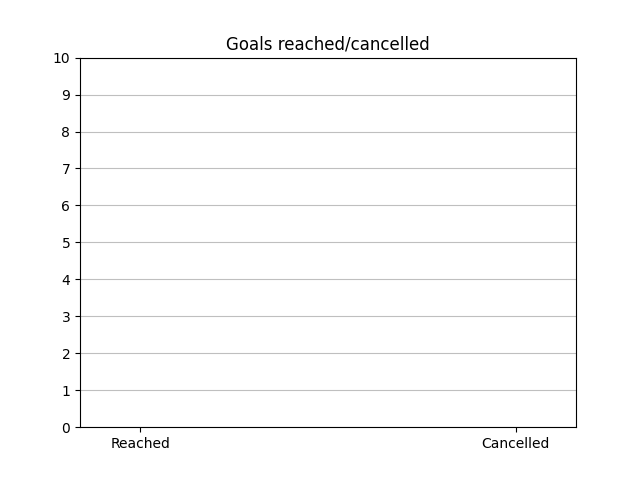

In [11]:
# Create the visualizer object
g_vis = GoalsVisualizer()
# Subscriber for the goals visualizer
sub_result = rospy.Subscriber('/reaching_goal/result', assignment_2_2022.msg.PlanningActionResult, g_vis.goals_callback)

g_ani = FuncAnimation(g_vis.fig, g_vis.update_plot, interval=1000, cache_frame_data = False)
plt.show(block=True)